This notebook contains descriptive data analysis and pre-processing and application of ML techniques to predict hospital infection by fungus or bacteria among COVID-19 positeve patients.


In [55]:
# Última modificação: 24/04/2024

In [56]:
!pip install tensorflow
!pip install shap
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [57]:
# Libraries
import numpy as np
import pandas as pd
import random as rd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import os
import time
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer

!pip install 'openpyxl>=3.0.0'

Defaulting to user installation because normal site-packages is not writeable


  # 1.0 - Data integration





















## Datasets

In [58]:
ls

agrupado.xlsx*                    exames_infeccoes.xlsx
Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb*      pacientes_negativos.xlsx*
describe_2.xlsx*                  pacientes_positivos.xlsx*
describe.xlsx*                    Patients_selection.ipynb*
exames_COVID19_considerados.xlsx  Plots/
exames_COVID19_todos.xlsx         RowDatasets/


In [59]:


# "HSL_Pacientes_3.csv"
df_pacientes = pd.read_csv('RowDatasets/HSL_Pacientes_3.csv', sep='|')
print("df_pacientes...............: ", df_pacientes.shape)

# remove duplicate examples
df_pacientes = df_pacientes.drop_duplicates()
print("df_pacientes sem duplicatos: ", df_pacientes.shape, "\n")

# "HSL_Exames_3.csv" 
df_exames = pd.read_csv('RowDatasets/HSL_Exames_3.csv', sep='|')
print("df_exames..................: ", df_exames.shape)

# removal duplicate examples
df_exames = df_exames.drop_duplicates()
print("df_exames sem duplicatos...: ", df_exames.shape, "\n")

# "Exame.Analito" column create
df_exames["Exame.Analito"] = df_exames["DE_EXAME"]+"."+df_exames["DE_ANALITO"]

# "HSL_Desfechos_3.csv"
df_desfecho = pd.read_csv('RowDatasets/HSL_Desfechos_3.csv', sep='|')
print("df_desfecho................: ", df_desfecho.shape)

# remove duplicate example
df_desfecho = df_desfecho.drop_duplicates()
print("df_desfecho em duplicatos..: ", df_desfecho.shape)

# add 'outcome' column in front of the same "patient id" and "service id"
df_sirio = df_exames.merge(df_desfecho, on = ["ID_PACIENTE", "ID_ATENDIMENTO"], how = "left")
print("\ndf_sirio...................: ", df_sirio.shape)

# SEX and and birth year obtained from HSL PACIENTES spreadsheet
pacientes_2 = df_pacientes[['ID_PACIENTE','aa_nascimento','IC_SEXO']]

# add aa_nascimento column on dataframe
df_sirio = df_sirio.merge(pacientes_2, on=['ID_PACIENTE'], how='left')
print("Pacientes únicos...........: ", df_sirio["ID_PACIENTE"].nunique(), '\n')

# Exame.Analito column criate
df_sirio["Exame.Analito"] = df_sirio["DE_EXAME"]+"."+df_sirio["DE_ANALITO"]

df_sirio.columns

df_pacientes...............:  (8971, 7)
df_pacientes sem duplicatos:  (8971, 7) 

df_exames..................:  (1463834, 9)
df_exames sem duplicatos...:  (1436537, 9) 

df_desfecho................:  (42691, 8)
df_desfecho em duplicatos..:  (42691, 8)

df_sirio...................:  (1436537, 16)
Pacientes únicos...........:  8971 



Index(['ID_PACIENTE', 'ID_ATENDIMENTO', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME',
       'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA',
       'Exame.Analito', 'DT_ATENDIMENTO', 'DE_TIPO_ATENDIMENTO', 'ID_CLINICA',
       'DE_CLINICA', 'DT_DESFECHO', 'DE_DESFECHO', 'aa_nascimento', 'IC_SEXO'],
      dtype='object')

First patient input

In [60]:
df_desfecho['DT_ATENDIMENTO'] = pd.to_datetime(df_desfecho['DT_ATENDIMENTO'])

ls_atendimento = df_desfecho['DT_ATENDIMENTO']

ls_atendimento = ls_atendimento.sort_values()

ls_atendimento.min()

/tmp/ipykernel_6540/1327082131.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_desfecho['DT_ATENDIMENTO'] = pd.to_datetime(df_desfecho['DT_ATENDIMENTO'])


Timestamp('2020-02-26 00:00:00')

Last patient output

In [61]:
ls_desfecho = df_desfecho['DT_DESFECHO']

# Identificando os índices das linhas com DDMMAA
linhas_com_ddmmaa = ls_desfecho.loc[ls_desfecho == 'DDMMAA'].index

# Excluindo as linhas com DDMMAA
ls_desfecho = ls_desfecho.drop(linhas_com_ddmmaa)

# Imprimindo a série sem DDMMAA
ls_desfecho = pd.to_datetime(ls_desfecho)

ls_desfecho.sort_values()

ls_desfecho.max()

/tmp/ipykernel_6540/2555599839.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ls_desfecho = pd.to_datetime(ls_desfecho)


Timestamp('2020-12-29 00:00:00')

## Printing reference values for the interest exams 

The grouped spreadsheet contains the reference values for each exam. These values will be used for future data discretization.

In [62]:
ls

agrupado.xlsx*                    exames_infeccoes.xlsx
Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb*      pacientes_negativos.xlsx*
describe_2.xlsx*                  pacientes_positivos.xlsx*
describe.xlsx*                    Patients_selection.ipynb*
exames_COVID19_considerados.xlsx  Plots/
exames_COVID19_todos.xlsx         RowDatasets/


In [63]:
valor_referencia = df_exames[["DE_ANALITO","DE_EXAME", "CD_UNIDADE", "DE_VALOR_REFERENCIA"]]
agrupado = valor_referencia.groupby("DE_ANALITO")
agrupado = agrupado.first()

print(agrupado.shape)

agrupado.colums = ["analito", "exame", "unidade", "referencia"]

agrupado.to_excel("agrupado.xlsx")

(954, 3)


/tmp/ipykernel_6540/3142648951.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  agrupado.colums = ["analito", "exame", "unidade", "referencia"]


In [64]:
agrupado = pd.read_excel("agrupado.xlsx")
agrupado.head()

,DE_ANALITO,DE_EXAME,CD_UNIDADE,DE_VALOR_REFERENCIA
0,17-Alfa-Hidroxiprog.,17 Alfa Hidroxiprogesterona,ng/dL,Ver resultado tradicional
1,17-Hidroxi Pregnenolona,17 Hidroxipregnenolona,ng/dL,Ver resultado tradicional
2,183,Amilase,U/L,28 a 100
3,25OH-Vitamina D Total,"Vitamina D, 25 hidroxi (Vitamina D3), Soro",NaN,NaN
4,5-Nucleotidase,5-Nucleotidase,U/L,0 a 10


In [65]:
exs = ['ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP/INR',
       'TTPA - Paciente/Normal', 'Uréia', 'VCM', 'Volume plaquetário médio']

In [66]:
for index, row in agrupado.iterrows():
  if row['DE_ANALITO'] not in exs:
    agrupado.drop(index, inplace=True)

agrupado.to_excel("agrupado.xlsx")
    

# 2.0 - PATIENT EXCLUSION CRITERIA

## Only selected patients remain in the dataset construction

Positive patients

In [67]:
# positive patients spreadsheet import
df_pacientes_positivos = pd.read_excel('pacientes_positivos.xlsx', sheet_name='Sheet1')

# column to list transform
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

# removal non positive patients
df2 = df_sirio.copy(deep=True)
df2 = df2.loc[ df2['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df2.shape)
print("Pacientes únicos: ", df2["ID_PACIENTE"].nunique())

df2.head()

Lista pacientes positivos:  39 

dataframe 2.....:  (105220, 18)
Pacientes únicos:  39


,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO
82,EAADD95C88D58DDAAA38953C8E49DD6C,03302B5E5FA2C352DFB0D8994380166E,12/10/2020,Unidades de Internação,Acido Fólico,Ácido fólico,"11,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,09/10/2020,Internado,1.0,Clínica Médica,14/10/2020,Alta médica melhorado,YYYY,F
88,EAADD95C88D58DDAAA38953C8E49DD6C,FA0D6A6FC391A0BF0179DFEC702EAC07,02/03/2020,Unidades de Internação,Acido Fólico,Ácido fólico,superior a 24,ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,02/03/2020,Internado,1.0,Clínica Médica,08/03/2020,Alta médica melhorado,YYYY,F
113,BF74EEB9A5084C650B62388BEC2DF076,D492FEA31CBCA4F00A4C93F5C2611C18,14/05/2020,UTI,Acido Fólico,Ácido fólico,"5,7",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,23/03/2020,Internado,1.0,Clínica Médica,29/06/2020,Alta médica melhorado,1940,M
277,EAADD95C88D58DDAAA38953C8E49DD6C,03302B5E5FA2C352DFB0D8994380166E,12/10/2020,Unidades de Internação,Antígeno Carcinoembriogênico (CEA),CEA,731,microg/L,"Até 5,0",Antígeno Carcinoembriogênico (CEA).CEA,09/10/2020,Internado,1.0,Clínica Médica,14/10/2020,Alta médica melhorado,YYYY,F
280,EAADD95C88D58DDAAA38953C8E49DD6C,084C7AE0E3C65D05D83C5A1470E480EF,23/09/2020,Unidades de Internação,Antígeno Carcinoembriogênico (CEA),CEA,625,microg/L,"Até 5,0",Antígeno Carcinoembriogênico (CEA).CEA,23/09/2020,Internado,1.0,Clínica Médica,26/09/2020,Alta médica melhorado,YYYY,F


Negative patients

In [68]:
# Negative patients spreadsheet import
df_pacientes_negativos = pd.read_excel('pacientes_negativos.xlsx', sheet_name='Sheet1')

# Column to list
lista_pacientes = df_pacientes_negativos[0].values.tolist()
print("Lista pacientes negativos: ", len(lista_pacientes), "\n")

# Eliminated non negative patients
df2_neg = df_sirio.copy(deep=True)
df2_neg = df2_neg.loc[ df2_neg['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df2_neg.shape)
print("Pacientes únicos: ", df2_neg["ID_PACIENTE"].nunique())

df2_neg.head()

Lista pacientes negativos:  513 

dataframe 2.....:  (424496, 18)
Pacientes únicos:  513


,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO
12,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,25/08/2020,Hemodiálise,Acido Fólico,Ácido fólico,"10,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,24/08/2020,Ambulatorial,15.0,Hemodiálise,25/08/2020,Alta Administrativa,1935,M
17,F7485478A910C42521C79D6400FC3BA0,229D7D60D205EF5A0E0BBA5E7083AB73,22/09/2020,Laboratório de Patologia Clínica,Acido Fólico,Ácido fólico,"11,4",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,22/09/2020,Externo,31.0,Exames,23/09/2020,Alta Administrativa,1939,M
29,75A770B4CD34F0E7AD9C7EAB4DA71735,598E644A09F6492B8A97CE766A19313F,15/10/2020,Tomografia,Acido Fólico,Ácido fólico,"7,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,15/10/2020,Externo,20.0,Procedimentos,15/10/2020,Alta Administrativa,1939,M
32,966F5B1255E6C2AFF91FBAD12D62D3DB,041FE1040CA67B877B3BCC6D710DA2B0,20/08/2020,Centro de Oncologia,Acido Fólico,Ácido fólico,"22,5",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,20/08/2020,Externo,31.0,Exames,20/08/2020,Alta Administrativa,1965,F
33,1A7196261C9935EDDB96E2D71A87DCE9,967488D9375B93939C70A15946B26587,15/10/2020,Centro de Oncologia,Acido Fólico,Ácido fólico,superior a 24,ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,15/10/2020,Externo,31.0,Exames,15/10/2020,Alta Administrativa,1940,F


In [69]:
df2 = pd.concat([df2, df2_neg])
df2["ID_PACIENTE"].nunique()

552

# 3.0 - Exams selection




## 3.1 Colection date

In [70]:
df3 = df2.copy(deep=True)

# date to datetime
df3['DT_ATENDIMENTO'] = pd.to_datetime(df3['DT_ATENDIMENTO'],  format="%d/%m/%Y")
df3['DT_COLETA'] = pd.to_datetime(df3['DT_COLETA'],  format="%d/%m/%Y")
df3['DT_DESFECHO'] = pd.to_datetime(df3['DT_COLETA'],  format="%d/%m/%Y")

# exams period
df3['PERIODO_EXAMES'] = (df3['DT_COLETA']-df3['DT_ATENDIMENTO']).dt.days
print(df3.shape, '\n')

# Exams selection. Select only exames made from 0 to 3 days of internation (0 <= period <= 3) 
df3 = df3[ df3["PERIODO_EXAMES"] >= 0 ]
df3 = df3[ df3["PERIODO_EXAMES"] <= 3 ]
print(df3.shape, '\n')

df3["ID_PACIENTE"].nunique()

(529716, 19) 

(182658, 19) 



552

## 3.2 Exams elimination (with more than 50% missing data)

In [71]:
df3_2 = df3.copy(deep=True)

#Considera apenas o último exame no caso de repetidos no mesmo dia.
df3_2 = df3_2.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df3_2.shape )

#solucionando nome colunas dois niveis
df3_2.columns = [ '_'.join(x) for x in df3_2.columns ]
df3_2.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df3_2 = df3_2.pivot_table( index=['PACIENTE'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()

#solucionando nome colunas dois niveis
df3_2.columns = [ ''.join(x) for x in df3_2.columns ]
df3_2.head()

(106535, 5)


,PACIENTE,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-Hidroxiprog.,"RESULTADOAcetilcolina, Anticorpo Anti.Acetilcolina","RESULTADOAcetilcolina, Anticorpos Bloqueadores do Receptor, soro.Acetilcolina - Anticorpos bloqueadores","RESULTADOAcido Ascorbico, plasma.Ácido ascorbico, plasma",RESULTADOAcido Fólico.Ácido fólico,RESULTADOAdenosina Deaminase (ADA).ADA,"RESULTADOAdenovírus PCR Quantitativo.Adenovirus, determinação quantitativa DNA","RESULTADOAlbumina, soro.Albumina",RESULTADOAlbumina.Albumina,...,"RESULTADOVírus respiratórios, sincicial, influenza, parainfluenza, adeno, fluorescência.Vírus respiratórios - detecção",RESULTADOZinco.Zinco,"RESULTADOÁcido Lático, Sangue Arterial.Lactato, arterial","RESULTADOÁcido Metilmalônico, Soro.Ácido metilmalonico, soro","RESULTADOÁcido Valpróico, Dosagem.Ácido Valpróico",RESULTADOÁcido Úrico Urinário.Período de coleta (horas),RESULTADOÁcido Úrico Urinário.Volume (mL),"RESULTADOÁcido Úrico Urinário.Ácido Úrico, urina","RESULTADOÁcido Úrico, soro.Ácido Úrico",RESULTADOÁcido Úrico.Ácido Úrico
0,004688799FD293C3ABE0A07209FD8B75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,5"
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3,4",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0183BA4D9368936BAD131398B55CDDC3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01A30B6624DDB49F16CA4311CC37D65F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
teste = df3_2[["PACIENTE","RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais", "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"]]
teste.head()

,PACIENTE,"RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais","RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"
0,004688799FD293C3ABE0A07209FD8B75,NEGATIVO,NEGATIVO
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NEGATIVO,NEGATIVO
2,009F0D6B3BA6C0E2D406585697D679EB,NEGATIVO,NEGATIVO
3,0183BA4D9368936BAD131398B55CDDC3,NEGATIVO,NEGATIVO
4,01A30B6624DDB49F16CA4311CC37D65F,NEGATIVO,NEGATIVO


In [73]:
# calcula a porcentagem de valores ausentes
ausentes = df3_2.isnull().sum()
ausentes = pd.DataFrame([ausentes])
ausentes = ausentes.drop(columns=['PACIENTE'])
ausentes = ausentes.T
ausentes['Nulos por cento'] = ''
total_pacientes = df3_2["PACIENTE"].nunique()
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/total_pacientes)*100, 2)
        ausentes.loc[index,'Nulos por cento'] = porcentagem
ausentes = ausentes.sort_values(by=[0], ascending=False)
ausentes.reset_index(inplace=True, drop=False)
ausentes.columns = ["exame.analito", "valores nulos", "nulos por cento" ]
print(ausentes.shape, '\n')
ausentes

(934, 3) 



,exame.analito,valores nulos,nulos por cento
0,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-H...,551,99.82
1,"RESULTADOHemograma, sangue total.Blastos (%)",551,99.82
2,RESULTADOUrina Tipo I - Jato Final.Eritrócitos...,551,99.82
3,"RESULTADOUrina Tipo I - Jato Final.Glicose, ur...",551,99.82
4,"RESULTADOUrina Tipo I - Jato Final.Leucócitos,...",551,99.82
...,...,...,...
929,RESULTADOHemograma.Neutrófilos (%),7,1.27
930,RESULTADOHemograma.Plaquetas,7,1.27
931,RESULTADOHemograma.RDW,7,1.27
932,RESULTADOHemograma.VCM,7,1.27


In [74]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
878,"RESULTADOHemocultura para aeróbios, por maldi-...",181,32.79


In [75]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
879,"RESULTADOHemocultura para anaeróbios, por mald...",180,32.61


In [76]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios" ]

,exame.analito,valores nulos,nulos por cento
727,"RESULTADOHemocultura, para Aeróbios, Vários Ma...",498,90.22


In [77]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios" ]

,exame.analito,valores nulos,nulos por cento
804,"RESULTADOHemocultura, para Anaeróbios, Vários ...",477,86.41


In [78]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOFungos, Cultura.Fungos, Cultura" ]

,exame.analito,valores nulos,nulos por cento
718,"RESULTADOFungos, Cultura.Fungos, Cultura",504,91.3


In [79]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Fungos, Varios Materiais.Hemocultura Fungos" ]

,exame.analito,valores nulos,nulos por cento
663,"RESULTADOHemocultura, para Fungos, Varios Mate...",527,95.47


In [80]:
# Elimina exames com mais de 50% de valores ausentes
ausentes = ausentes[ ausentes["nulos por cento"] < 50]
print(ausentes.shape, '\n')
ausentes

(78, 3) 



,exame.analito,valores nulos,nulos por cento
856,"RESULTADOUrina, Cultura - Jato Médio.Urina, Cu...",275,49.82
857,"RESULTADOUrina, Cultura - Jato Médio.Cultura d...",272,49.28
858,RESULTADOFósforo.Fósforo,240,43.48
859,RESULTADOUrina Tipo I - Jato Medio.Eritrócitos...,234,42.39
860,"RESULTADOUrina Tipo I - Jato Medio.Densidade, ...",234,42.39
...,...,...,...
929,RESULTADOHemograma.Neutrófilos (%),7,1.27
930,RESULTADOHemograma.Plaquetas,7,1.27
931,RESULTADOHemograma.RDW,7,1.27
932,RESULTADOHemograma.VCM,7,1.27


In [81]:
# gerando lista de exames com menos de 50% de missing values
temp = ausentes["exame.analito"].unique()
lista_exames = temp.tolist()
print("Tamanho lista de exames com menos de 50% NaN:", len(lista_exames), '\n')

# adquirindo novamente a lista de exames
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')
lista_exames_bac = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames bacterias: ", len(lista_exames_bac), '\n')

# adquirindo novamente a lista de exames (COVID)
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
df_exames_covid_selecionados = pd.read_excel('exames_COVID19_considerados.xlsx', sheet_name='lista_exames')
lista_exames_covid = df_exames_covid_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames covid: ", len(lista_exames_covid), '\n')

# retirando a palavra "RESULTADO" do nome dos exames
nova_lista = []
for i in lista_exames:
    nova_lista.append(i[9:])

# juntando listas
for i in lista_exames_bac:
    nova_lista.append(i)
for i in lista_exames_covid:
    nova_lista.append(i)
    print(i)
print('\nTamanho lista final de exames:', len(nova_lista), '\n')

Tamanho lista de exames com menos de 50% NaN: 78 

[Errno 2] No such file or directory: '/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3'
/home/filipe/Documentos/GitHub/HCAIprediction/DatasetsConstruction

Tamanho lista de exames bacterias:  6 

[Errno 2] No such file or directory: '/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3'
/home/filipe/Documentos/GitHub/HCAIprediction/DatasetsConstruction

Tamanho lista de exames covid:  2 

COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)
Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)

Tamanho lista final de exames: 86 



/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [82]:
nova_lista

['Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Fósforo.Fósforo',
 'Urina Tipo I - Jato Medio.Eritrócitos, urina',
 'Urina Tipo I - Jato Medio.Densidade, urina',
 'Urina Tipo I - Jato Medio.Cilindros, urina',
 'Urina Tipo I - Jato Medio.Glicose, urina isol',
 'Urina Tipo I - Jato Medio.Leucócitos, urina',
 'Urina Tipo I - Jato Medio.Nitrito, urina',
 'Urina Tipo I - Jato Medio.pH, urina',
 'Urina Tipo I - Jato Medio.Células Epiteliais',
 'Urina Tipo I - Jato Medio.Proteínas, urina isolada',
 'Urina Tipo I - Jato Medio.Cor, urina',
 'Urina Tipo I - Jato Medio.C.Cetônicos, urina',
 'Urina Tipo I - Jato Medio.Bilirrubina,urina',
 'Urina Tipo I - Jato Medio.Aspecto, urina',
 'Urina Tipo I - Jato Medio.Urobilinogênio,urina',
 'Fibrinogênio, Dosagem Do.Fibrinogenio',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomi

In [83]:
# exams selection (only exams from "nova_lista" list)

df3_2 = df3.loc[ df3["Exame.Analito"].isin(nova_lista) ]

df3_2.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES
620,EAADD95C88D58DDAAA38953C8E49DD6C,FC22FD6576E0FEAE71BA58F030FA32F1,2020-03-28,Laboratório de Patologia Clínica,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,"0,29",mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-03-28,Externo,31.0,Exames,2020-03-28,Alta Administrativa,YYYY,F,0.0
653,EAADD95C88D58DDAAA38953C8E49DD6C,A7652413A46864D7B9D346EC3D881BFE,2020-10-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,"0,15",mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Ambulatorial,17.0,Oncologia,2020-10-15,Alta Administrativa,YYYY,F,0.0
654,EAADD95C88D58DDAAA38953C8E49DD6C,0EDE1CDDA78409B5419530E695D7954B,2020-04-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,"0,43",mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-04-15,Ambulatorial,17.0,Oncologia,2020-04-15,Alta Administrativa,YYYY,F,0.0
677,EAADD95C88D58DDAAA38953C8E49DD6C,4B96DCA5849BD7F434232EFFD37B4809,2020-05-21,Central de Agendamento do SADT,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,"0,28",mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-05-21,Ambulatorial,17.0,Oncologia,2020-05-21,Alta Administrativa,YYYY,F,0.0
815,EAADD95C88D58DDAAA38953C8E49DD6C,221B7B4BF8F94401A0CE1CB04675C6DD,2020-10-15,Unidades de Internação,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,"0,16",mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Internado,1.0,Clínica Médica,2020-10-15,Alta médica melhorado,YYYY,F,0.0


## 3.3 Non numerical exams elimination

In [84]:
df3_3 = df3_2.copy(deep=True)

# replace ',' por '.'.
df3_3['DE_RESULTADO'] = [x.replace(',', '.') for x in df3_3['DE_RESULTADO']] 

df3_3.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES
620,EAADD95C88D58DDAAA38953C8E49DD6C,FC22FD6576E0FEAE71BA58F030FA32F1,2020-03-28,Laboratório de Patologia Clínica,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.29,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-03-28,Externo,31.0,Exames,2020-03-28,Alta Administrativa,YYYY,F,0.0
653,EAADD95C88D58DDAAA38953C8E49DD6C,A7652413A46864D7B9D346EC3D881BFE,2020-10-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.15,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Ambulatorial,17.0,Oncologia,2020-10-15,Alta Administrativa,YYYY,F,0.0
654,EAADD95C88D58DDAAA38953C8E49DD6C,0EDE1CDDA78409B5419530E695D7954B,2020-04-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.43,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-04-15,Ambulatorial,17.0,Oncologia,2020-04-15,Alta Administrativa,YYYY,F,0.0
677,EAADD95C88D58DDAAA38953C8E49DD6C,4B96DCA5849BD7F434232EFFD37B4809,2020-05-21,Central de Agendamento do SADT,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.28,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-05-21,Ambulatorial,17.0,Oncologia,2020-05-21,Alta Administrativa,YYYY,F,0.0
815,EAADD95C88D58DDAAA38953C8E49DD6C,221B7B4BF8F94401A0CE1CB04675C6DD,2020-10-15,Unidades de Internação,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.16,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Internado,1.0,Clínica Médica,2020-10-15,Alta médica melhorado,YYYY,F,0.0


In [85]:
# function to verify if the variable is numeric

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# function test
print( is_number("99.99") )
print( is_number("1") )
print( is_number("A") )


True
True
False


In [86]:
# new column
df3_3['Tipo_resultado'] = np.nan

# fuction to label numerical or non numerical
def numerico(x):
    return is_number(x['DE_RESULTADO'])

# call function
df3_3['Tipo_resultado'] = df3_3.apply( lambda row : numerico(row), axis = 1)

df3_3.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES,Tipo_resultado
620,EAADD95C88D58DDAAA38953C8E49DD6C,FC22FD6576E0FEAE71BA58F030FA32F1,2020-03-28,Laboratório de Patologia Clínica,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.29,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-03-28,Externo,31.0,Exames,2020-03-28,Alta Administrativa,YYYY,F,0.0,True
653,EAADD95C88D58DDAAA38953C8E49DD6C,A7652413A46864D7B9D346EC3D881BFE,2020-10-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.15,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Ambulatorial,17.0,Oncologia,2020-10-15,Alta Administrativa,YYYY,F,0.0,True
654,EAADD95C88D58DDAAA38953C8E49DD6C,0EDE1CDDA78409B5419530E695D7954B,2020-04-15,Centro de Oncologia,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.43,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-04-15,Ambulatorial,17.0,Oncologia,2020-04-15,Alta Administrativa,YYYY,F,0.0,True
677,EAADD95C88D58DDAAA38953C8E49DD6C,4B96DCA5849BD7F434232EFFD37B4809,2020-05-21,Central de Agendamento do SADT,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.28,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-05-21,Ambulatorial,17.0,Oncologia,2020-05-21,Alta Administrativa,YYYY,F,0.0,True
815,EAADD95C88D58DDAAA38953C8E49DD6C,221B7B4BF8F94401A0CE1CB04675C6DD,2020-10-15,Unidades de Internação,Bilirrubinas Total E Fracoes,Bilirrubina Indireta,0.16,mg/dL,"0,20 a 0,80",Bilirrubinas Total E Fracoes.Bilirrubina Indireta,2020-10-15,Internado,1.0,Clínica Médica,2020-10-15,Alta médica melhorado,YYYY,F,0.0,True


In [87]:
df3_3[ df3_3["Tipo_resultado"] == False].head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES,Tipo_resultado
15419,EAADD95C88D58DDAAA38953C8E49DD6C,37C071F472ED1FDE0DB58DBBC7129334,2020-03-17,Unidades de Internação,"Proteína C Reativa, plasma",Proteína C-Reativa,inferior a 0.03,mg/dL,Ver resultado tradicional,"Proteína C Reativa, plasma.Proteína C-Reativa",2020-03-17,Internado,1.0,Clínica Médica,2020-03-17,Alta médica melhorado,YYYY,F,0.0,False
50294,BF74EEB9A5084C650B62388BEC2DF076,D492FEA31CBCA4F00A4C93F5C2611C18,2020-03-23,UTI,"COVID-19-PCR para SARS-COV-2, Vários Materiais...",Coronavírus (2019-nCoV),DETECTADO,NaN,Não detectado,"COVID-19-PCR para SARS-COV-2, Vários Materiais...",2020-03-23,Internado,1.0,Clínica Médica,2020-03-23,Alta médica melhorado,1940,M,0.0,False
50313,EAADD95C88D58DDAAA38953C8E49DD6C,22E8C954C56B097007E2CFA8076BB276,2020-04-01,Unidades de Internação,"COVID-19-PCR para SARS-COV-2, Vários Materiais...",Coronavírus (2019-nCoV),DETECTADO,NaN,Não detectado,"COVID-19-PCR para SARS-COV-2, Vários Materiais...",2020-04-01,Internado,1.0,Clínica Médica,2020-04-01,Alta médica melhorado,YYYY,F,0.0,False
51802,EAADD95C88D58DDAAA38953C8E49DD6C,A7652413A46864D7B9D346EC3D881BFE,2020-10-15,Centro de Oncologia,"Calculo da Estimativa da Taxa, de Filtracao Gl...",Cálculo p/não afrodescendente MDRD,superior a 60,mL/minuto,Superior a 60,"Calculo da Estimativa da Taxa, de Filtracao Gl...",2020-10-15,Ambulatorial,17.0,Oncologia,2020-10-15,Alta Administrativa,YYYY,F,0.0,False
51807,EAADD95C88D58DDAAA38953C8E49DD6C,10DEAB1D7D671842499946B69DAB8CD3,2020-06-03,Centro de Oncologia,"Calculo da Estimativa da Taxa, de Filtracao Gl...",Cálculo p/não afrodescendente MDRD,superior a 60,mL/minuto,Superior a 60,"Calculo da Estimativa da Taxa, de Filtracao Gl...",2020-06-03,Ambulatorial,20.0,Procedimentos,2020-06-03,Alta Administrativa,YYYY,F,0.0,False


In [88]:
# drop non numerical
df3_3.drop(df3_3.loc[df3_3['Tipo_resultado']==False].index, inplace=True)

In [89]:
df3_3[ df3_3["Tipo_resultado"] == False]

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES,Tipo_resultado


In [90]:
# Converte resultado de string para float
df3_3['DE_RESULTADO'] = df3_3['DE_RESULTADO'].astype(float) 

# 4.0 - GROUPBY 

In [91]:
df4 = df3_3.copy(deep=True)

# Only considers the last exam in the case of repeat exams
df4 = df4.groupby(['ID_PACIENTE','aa_nascimento','IC_SEXO','DE_ANALITO']).agg({'DT_COLETA': ['max'], 'DE_RESULTADO' : ['last']}).reset_index()

df4.head(3)


,ID_PACIENTE,aa_nascimento,IC_SEXO,DE_ANALITO,DT_COLETA,DE_RESULTADO
,,,,,max,last
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2020-11-23,32.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2020-11-23,31.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-2.8


In [92]:
df4.columns = ['ID_PACIENTE', 'Idade','Sexo', 'DE_ANALITO','DT_COLETA', 'DE_RESULTADO']

df4.head(3)

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2020-11-23,32.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2020-11-23,31.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-2.8


In [93]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26769 entries, 0 to 26768
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID_PACIENTE   26769 non-null  object        
 1   Idade         26769 non-null  object        
 2   Sexo          26769 non-null  object        
 3   DE_ANALITO    26769 non-null  object        
 4   DT_COLETA     26769 non-null  datetime64[ns]
 5   DE_RESULTADO  26769 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.2+ MB


In [94]:
df4["ID_PACIENTE"].nunique()

550

## Eliminates patients who do not have a birth date 

In [95]:
df4.drop(df4.loc[df4['Idade']=='AAAA'].index, inplace=True)
df4.drop(df4.loc[df4['Idade']=='YYYY'].index, inplace=True)

df4['Idade'] = df4['Idade'].astype(int)

df4['Idade'] = 2022 - df4['Idade']

df4.head(3)

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,69,M,ALT (TGP),2020-11-23,32.0
1,004688799FD293C3ABE0A07209FD8B75,69,M,AST (TGO),2020-11-23,31.0
2,004688799FD293C3ABE0A07209FD8B75,69,M,BE venoso,2020-10-24,-2.8


# 5.0 - PIVOTATION FOR EXAMS TO BECOME COLUMNS

In [96]:
df5 = df4.copy(deep=True)

print("\ndataframe df5: ", df5.shape)
print("Pacientes únicos: ", df5["ID_PACIENTE"].nunique(), '\n')

# pivot_table
df5 = df5.pivot_table( index=['ID_PACIENTE', 'Idade', 'Sexo'],
                                     values=['DE_RESULTADO'],
                      
                                     columns=['DE_ANALITO'],
                                     
                                     aggfunc=['last'] ).reset_index()


# solving two-level column problem
df5.columns = [ ''.join(x) for x in df5.columns ]

colunas = ["ID_PACIENTE", "Idade", "Sexo"]
for i in df5.columns:
    if (i != 'ID_PACIENTE') and (i!= 'Idade') and (i!='Sexo'):
        colunas.append(i[16:]) 

df5.columns = colunas

df5.head()

# %cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/ML
# df5.to_excel("parcial.xlsx")


dataframe df5:  (24117, 6)
Pacientes únicos:  499 



,ID_PACIENTE,Idade,Sexo,ALT (TGP),AST (TGO),BE venoso,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Tempo de Protrombina,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso
0,004688799FD293C3ABE0A07209FD8B75,69,M,32.0,31.0,-2.8,10.0,0.1,0.21,0.15,...,11.3,NaN,NaN,91.0,96.0,10.6,30.0,7.44,5.0,59.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,M,25.0,33.0,NaN,10.0,0.1,0.19,0.15,...,10.9,NaN,NaN,38.0,89.5,10.3,NaN,NaN,NaN,NaN
2,0183BA4D9368936BAD131398B55CDDC3,69,M,142.0,75.0,NaN,10.0,0.2,0.19,0.14,...,11.6,NaN,NaN,50.0,84.4,10.8,NaN,NaN,NaN,NaN
3,01A30B6624DDB49F16CA4311CC37D65F,38,M,25.0,22.0,NaN,10.0,0.2,0.10,0.09,...,NaN,NaN,NaN,25.0,83.0,9.4,NaN,NaN,7.0,NaN
4,02367C393B8487123744A46CFBB91A28,74,M,13.0,28.0,0.9,10.0,0.2,0.18,0.12,...,12.3,NaN,NaN,39.0,94.5,9.7,35.0,7.45,6.0,28.0


# 6.0 Missing values

In [97]:
df6 = df5.copy(deep=True)

ausentes = df6.isnull().sum()

ausentes = pd.DataFrame([ausentes])

ausentes = ausentes.drop(columns=['ID_PACIENTE'])

ausentes = ausentes.T

print(ausentes.sort_values(by=[0]))

                                  0
Idade                             0
Sexo                              0
Creatinina                        2
Eritrócitos                       5
Hematócrito                       5
...                             ...
Cálculo p/afrodescendente MDRD  391
Glicose, urina isol             450
C.Cetônicos, urina              463
Troponina                       472
Urobilinogênio,urina            486

[66 rows x 1 columns]


In [98]:
# Percent calc
ausentes['Nulos por cento'] = ''
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/499)*100, 2)
        ausentes.loc[index,'Nulos por cento'] = porcentagem

ausentes = ausentes.sort_values(by=[0], ascending=False)

ausentes.reset_index(inplace=True, drop=False)

ausentes.head(30)

,index,0,Nulos por cento
0,"Urobilinogênio,urina",486,97.39
1,Troponina,472,94.59
2,"C.Cetônicos, urina",463,92.79
3,"Glicose, urina isol",450,90.18
4,Cálculo p/afrodescendente MDRD,391,78.36
5,Cálculo p/não afrodescendente MDRD,332,66.53
6,"Proteínas, urina isolada",327,65.53
7,Fósforo,222,44.49
8,"Eritrócitos, urina",219,43.89
9,"Leucócitos, urina",215,43.09


In [99]:
# Checking exams with more than 50% NaN for elimination
ausentes.drop(ausentes.loc[ausentes['Nulos por cento']<50].index, inplace=True)
exames_eliminar = ausentes['index'].values.tolist()
exames_eliminar

['Urobilinogênio,urina',
 'Troponina',
 'C.Cetônicos, urina',
 'Glicose, urina isol',
 'Cálculo p/afrodescendente MDRD',
 'Cálculo p/não afrodescendente MDRD',
 'Proteínas, urina isolada']

In [100]:
df6 = df6.drop(columns=(exames_eliminar))
print(df6.shape)
df6.head(3)

(499, 60)


,ID_PACIENTE,Idade,Sexo,ALT (TGP),AST (TGO),BE venoso,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,TTPA - Paciente/Normal,TTPA-Normal do dia,Tempo de Protrombina,Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso
0,004688799FD293C3ABE0A07209FD8B75,69,M,32.0,31.0,-2.8,10.0,0.1,0.21,0.15,...,0.94,27.8,11.3,91.0,96.0,10.6,30.0,7.44,5.0,59.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,M,25.0,33.0,NaN,10.0,0.1,0.19,0.15,...,1.11,28.7,10.9,38.0,89.5,10.3,NaN,NaN,NaN,NaN
2,0183BA4D9368936BAD131398B55CDDC3,69,M,142.0,75.0,NaN,10.0,0.2,0.19,0.14,...,0.95,27.8,11.6,50.0,84.4,10.8,NaN,NaN,NaN,NaN


In [101]:
print("Pacientes únicos: ", df6["ID_PACIENTE"].nunique(), "\n" )

print( df6.isnull().sum().sort_values() )


Pacientes únicos:  499 

ID_PACIENTE                                0
Idade                                      0
Sexo                                       0
Creatinina                                 2
Eritrócitos                                5
Hematócrito                                5
Hemoglobina                                5
Leucócitos                                 5
Linfócitos                                 5
Linfócitos (%)                             5
Monócitos                                  5
Monócitos (%)                              5
Neutrófilos                                5
Neutrófilos (%)                            5
Plaquetas                                  5
RDW                                        5
VCM                                        5
Eosinófilos (%)                            5
Eosinófilos                                5
HCM                                        5
Basófilos                                  5
Basófilos (%)                 

# 7.0 - Database preparation

In [102]:
df7 = df6.copy(deep=True)

print(df7.shape)

df7.head(3)

(499, 60)


,ID_PACIENTE,Idade,Sexo,ALT (TGP),AST (TGO),BE venoso,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,TTPA - Paciente/Normal,TTPA-Normal do dia,Tempo de Protrombina,Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso
0,004688799FD293C3ABE0A07209FD8B75,69,M,32.0,31.0,-2.8,10.0,0.1,0.21,0.15,...,0.94,27.8,11.3,91.0,96.0,10.6,30.0,7.44,5.0,59.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,M,25.0,33.0,NaN,10.0,0.1,0.19,0.15,...,1.11,28.7,10.9,38.0,89.5,10.3,NaN,NaN,NaN,NaN
2,0183BA4D9368936BAD131398B55CDDC3,69,M,142.0,75.0,NaN,10.0,0.2,0.19,0.14,...,0.95,27.8,11.6,50.0,84.4,10.8,NaN,NaN,NaN,NaN


In [103]:
for i in df7.columns:
  print(i)

ID_PACIENTE
Idade
Sexo
ALT (TGP)
AST (TGO)
BE venoso
Basófilos
Basófilos (%)
Bilirrubina Direta
Bilirrubina Indireta
Bilirrubina Total
CHCM
CK
Calcio Ionizavel
Creatinina
Cálculo p/afrodescendente CKD-EPI
Cálculo p/não afrodescendente CKD-EPI
DHL
Densidade, urina
Dimeros D, quant
Eosinófilos
Eosinófilos (%)
Eritrócitos
Eritrócitos, urina
Fibrinogenio
Fosfatase Alcalina
Fósforo
Gama-GT
Glicose
HCM
HCO3 venoso
Hematócrito
Hemoglobina
Leucócitos
Leucócitos, urina
Linfócitos
Linfócitos (%)
Magnésio
Monócitos
Monócitos (%)
Neutrófilos
Neutrófilos (%)
Plaquetas
Potássio
Proteína C-Reativa
RDW
Sat O2 venoso
Sódio
TP/INR
TTPA
TTPA - Paciente/Normal
TTPA-Normal do dia
Tempo de Protrombina
Uréia
VCM
Volume plaquetário médio
pCO2 venoso
pH venoso
pH, urina
pO2 venoso


## Manual attributes selection with Dr. Abrão

Only the variables must remain:

Idade

Sexo

ALT (TGP)

Basófilos

Bilirrubina Direta

Bilirrubina Indireta

CHCM

CK

Calcio Ionizavel

Creatinina

DHL

Dimeros D, quant

Eosinófilos

Eritrócitos, urina

Fibrinogenio

Fosfatase Alcalina

Gama-GT

Glicose

HCM

HCO3 venoso

Hemoglobina

Leucócitos

Leucócitos, urina

Linfócitos

Magnésio

Monócitos

Neutrófilos

Plaquetas

Potássio

Proteína C-Reativa

RDW

Sódio

TP/INR

TTPA Paciente/Normal

Uréia

VCM

Volume plaquetário médio

In [104]:
df7.columns

Index(['ID_PACIENTE', 'Idade', 'Sexo', 'ALT (TGP)', 'AST (TGO)', 'BE venoso',
       'Basófilos', 'Basófilos (%)', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'Bilirrubina Total', 'CHCM', 'CK',
       'Calcio Ionizavel', 'Creatinina', 'Cálculo p/afrodescendente CKD-EPI',
       'Cálculo p/não afrodescendente CKD-EPI', 'DHL', 'Densidade, urina',
       'Dimeros D, quant', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos',
       'Eritrócitos, urina', 'Fibrinogenio', 'Fosfatase Alcalina', 'Fósforo',
       'Gama-GT', 'Glicose', 'HCM', 'HCO3 venoso', 'Hematócrito',
       'Hemoglobina', 'Leucócitos', 'Leucócitos, urina', 'Linfócitos',
       'Linfócitos (%)', 'Magnésio', 'Monócitos', 'Monócitos (%)',
       'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas', 'Potássio',
       'Proteína C-Reativa', 'RDW', 'Sat O2 venoso', 'Sódio', 'TP/INR', 'TTPA',
       'TTPA - Paciente/Normal', 'TTPA-Normal do dia', 'Tempo de Protrombina',
       'Uréia', 'VCM', 'Volume plaquetário médio', 'pCO2 veno

In [105]:
var_selec = [             'ID_PACIENTE', 
                          'Idade', 
                          'Sexo', 
                          'ALT (TGP)',
                          'Basófilos', 
                          'Bilirrubina Direta',
                          'Bilirrubina Indireta', 
                          'CHCM', 
                          'CK',
                          'Calcio Ionizavel', 
                          'Creatinina', 
                          'DHL',
                          'Dimeros D, quant', 
                          'Eosinófilos',
                          'Eritrócitos, urina', 
                          'Fibrinogenio', 
                          'Fosfatase Alcalina', 
                          'Gama-GT',
                          'Glicose', 
                          'HCM', 
                          'HCO3 venoso', 
                          'Hemoglobina',
                          'Leucócitos', 
                          'Leucócitos, urina', 
                          'Linfócitos',
                          'Magnésio', 
                          'Monócitos', 
                          'Neutrófilos',
                          'Plaquetas', 
                          'Potássio', 
                          'Proteína C-Reativa', 
                          'RDW',
                          'Sódio',
                          'TP/INR', 
                          'TTPA - Paciente/Normal',
                          'Uréia', 
                          'VCM',
                          'Volume plaquetário médio']

In [106]:
var_selec

['ID_PACIENTE',
 'Idade',
 'Sexo',
 'ALT (TGP)',
 'Basófilos',
 'Bilirrubina Direta',
 'Bilirrubina Indireta',
 'CHCM',
 'CK',
 'Calcio Ionizavel',
 'Creatinina',
 'DHL',
 'Dimeros D, quant',
 'Eosinófilos',
 'Eritrócitos, urina',
 'Fibrinogenio',
 'Fosfatase Alcalina',
 'Gama-GT',
 'Glicose',
 'HCM',
 'HCO3 venoso',
 'Hemoglobina',
 'Leucócitos',
 'Leucócitos, urina',
 'Linfócitos',
 'Magnésio',
 'Monócitos',
 'Neutrófilos',
 'Plaquetas',
 'Potássio',
 'Proteína C-Reativa',
 'RDW',
 'Sódio',
 'TP/INR',
 'TTPA - Paciente/Normal',
 'Uréia',
 'VCM',
 'Volume plaquetário médio']

In [107]:
df7 = df7[var_selec]

## Dataset description

In [108]:
describe = df7.describe().T

describe.to_excel("describe.xlsx")

describe

,count,mean,std,min,25%,50%,75%,max
Idade,499.0,63.959920,17.127047,3.00,52.0000,66.00,78.00,91.00
ALT (TGP),466.0,45.027897,80.452920,6.00,18.0000,28.00,46.75,1461.00
Basófilos,494.0,18.562753,20.445324,0.00,10.0000,10.00,20.00,180.00
Bilirrubina Direta,374.0,0.270107,0.415468,0.04,0.1300,0.19,0.27,6.26
Bilirrubina Indireta,374.0,0.194519,0.227999,0.01,0.0925,0.14,0.24,2.84
CHCM,494.0,33.259312,1.226592,27.90,32.5000,33.30,34.10,36.30
CK,317.0,124.845426,161.185299,13.00,49.0000,80.00,138.00,2178.00
Calcio Ionizavel,365.0,1.223014,0.079440,0.96,1.1800,1.22,1.26,1.76
Creatinina,497.0,1.175191,0.885112,0.18,0.8000,0.96,1.19,7.53
DHL,412.0,613.490291,970.103470,217.00,404.0000,505.50,649.75,17849.00


## BOX PLOT

## Replacing female gender to 0 and male gender to 1

In [109]:
df7['SEXO'] = ''

for index, row in df7.iterrows():
        if row['Sexo'] == 'F':
            df7.loc[index,'SEXO'] = 0
    
        else:
            df7.loc[index,'SEXO'] = 1

df7['SEXO'] = df7['SEXO'].astype(int) 

In [110]:
df7['Sexo'].value_counts()

Sexo
M    343
F    156
Name: count, dtype: int64

<Axes: >

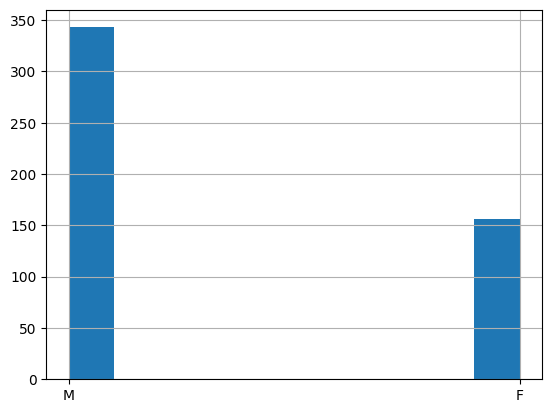

In [111]:
df7['Sexo'].hist()

In [112]:
df7['SEXO'].value_counts()

SEXO
1    343
0    156
Name: count, dtype: int64

In [341]:
#df7.columns

## Entering TARGET (INFECTION)

In [113]:
df7['INFEC'] = np.nan

df7.head(3)

,ID_PACIENTE,Idade,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,...,Proteína C-Reativa,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,SEXO,INFEC
0,004688799FD293C3ABE0A07209FD8B75,69,M,32.0,10.0,0.21,0.15,32.4,194.0,1.17,...,19.76,13.8,138.0,0.99,0.94,91.0,96.0,10.6,1,NaN
1,009F0D6B3BA6C0E2D406585697D679EB,57,M,25.0,10.0,0.19,0.15,34.8,153.0,NaN,...,11.04,13.1,137.0,0.97,1.11,38.0,89.5,10.3,1,NaN
2,0183BA4D9368936BAD131398B55CDDC3,69,M,142.0,10.0,0.19,0.14,32.8,106.0,1.24,...,13.61,12.7,138.0,1.00,0.95,50.0,84.4,10.8,1,NaN


In [114]:
# Spreadsheet import
df_pacientes_positivos = pd.read_excel('pacientes_positivos.xlsx', sheet_name='Sheet1')

# Column to list
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()

df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 1

teste = df7[ df7["INFEC"] == 1]

teste["ID_PACIENTE"].nunique()

/tmp/ipykernel_6540/437129906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 1


33

In [115]:
# negative patients spreadsheet import
df_pacientes_negativos = pd.read_excel('pacientes_negativos.xlsx', sheet_name='Sheet1')

# column to list
lista_pacientes = df_pacientes_negativos[0].values.tolist()

df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 0

teste = df7[ df7["INFEC"] == 0]

teste["ID_PACIENTE"].nunique()

/tmp/ipykernel_6540/1875798870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 0


466

In [116]:
df7["INFEC"].value_counts()

INFEC
0.0    466
1.0     33
Name: count, dtype: int64

In [117]:
df7["Infecção Hospitalar"] = " "

for index, row in df7.iterrows():
        if row['INFEC'] == 0:
            df7.loc[index,'Infecção Hospitalar'] = "negativo"
    
        else:
            df7.loc[index,'Infecção Hospitalar'] = "positivo"

df7.head(10)

,ID_PACIENTE,Idade,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,...,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,69,M,32.0,10.0,0.21,0.15,32.4,194.0,1.17,...,13.8,138.0,0.99,0.94,91.0,96.0,10.6,1,0.0,negativo
1,009F0D6B3BA6C0E2D406585697D679EB,57,M,25.0,10.0,0.19,0.15,34.8,153.0,NaN,...,13.1,137.0,0.97,1.11,38.0,89.5,10.3,1,0.0,negativo
2,0183BA4D9368936BAD131398B55CDDC3,69,M,142.0,10.0,0.19,0.14,32.8,106.0,1.24,...,12.7,138.0,1.00,0.95,50.0,84.4,10.8,1,0.0,negativo
3,01A30B6624DDB49F16CA4311CC37D65F,38,M,25.0,10.0,0.10,0.09,33.8,60.0,NaN,...,13.0,142.0,NaN,NaN,25.0,83.0,9.4,1,0.0,negativo
4,02367C393B8487123744A46CFBB91A28,74,M,13.0,10.0,0.18,0.12,33.1,72.0,1.14,...,13.1,135.0,1.10,1.20,39.0,94.5,9.7,1,0.0,negativo
5,023B1D40B2A154BBCC3A37EE25AD890D,84,M,NaN,30.0,0.17,0.15,32.9,NaN,NaN,...,14.8,NaN,1.10,1.13,40.0,89.4,8.9,1,0.0,negativo
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,59,F,12.0,30.0,0.07,0.09,30.8,55.0,1.39,...,14.4,142.0,1.10,1.04,59.0,84.7,9.6,0,0.0,negativo
7,02B84254C7AE3E96DCF97D23AE93C8C9,63,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,negativo
8,02F2F8FC72B4714F5C6B98C04EDB5913,85,F,13.0,0.0,0.15,0.10,33.3,75.0,NaN,...,16.5,NaN,0.91,0.96,62.0,92.8,12.2,0,0.0,negativo
9,0395F9016111258155141750CE8488C1,52,M,NaN,10.0,NaN,NaN,35.2,NaN,NaN,...,12.4,138.0,NaN,NaN,28.0,85.5,10.8,1,0.0,negativo


<Axes: >

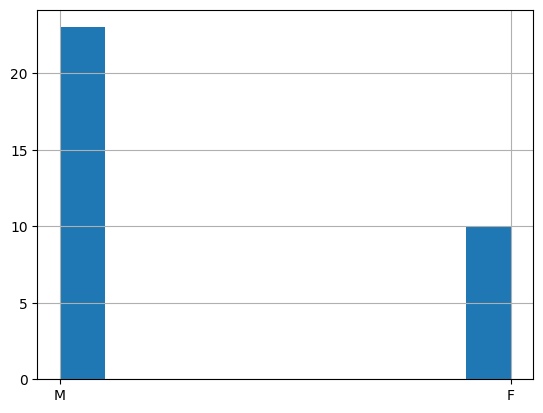

In [118]:
df7_infec = df7[ df7["INFEC"] == 1]
df7_infec["Sexo"].hist()

<Axes: >

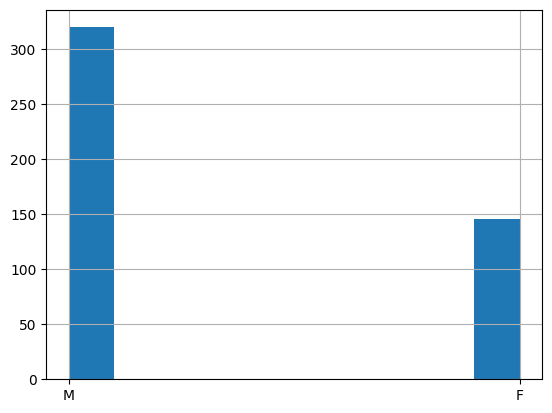

In [119]:
df7_infec = df7[ df7["INFEC"] == 0]
df7_infec["Sexo"].hist()

In [120]:
df7 = df7.drop(columns=["Sexo"])

In [350]:
def print_boxplot(atributo):
  plt.title(atributo, size=16)
  plt.gcf().set_size_inches(15, 3) # alterar tamanho
  #plt.xticks(range(0, 100, 10)) # mudar escala do eixo X
  
  #plt.xlabel( fontsize = 18) 
  #plt.ylabel( fontsize = 18)
  #plt.legend( fontsize = 18)
  plt.tick_params(labelsize=20) 
  
  ax = sns.boxplot(x=atributo, y="Infecção Hospitalar", data=df7)
  plt.savefig(atributo+'.png')
  plt.show()
  print("\n")

In [121]:
df7.columns

Index(['ID_PACIENTE', 'Idade', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP/INR',
       'TTPA - Paciente/Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'SEXO', 'INFEC', 'Infecção Hospitalar'],
      dtype='object')

In [122]:
df7.columns = ['ID_PACIENTE', 'Idade', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'SEXO', 'INFEC', 'Infecção Hospitalar']

In [123]:
df7.columns[1:-2]

Index(['Idade', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'SEXO'],
      dtype='object')

In [354]:
%cd plots

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_4/plots


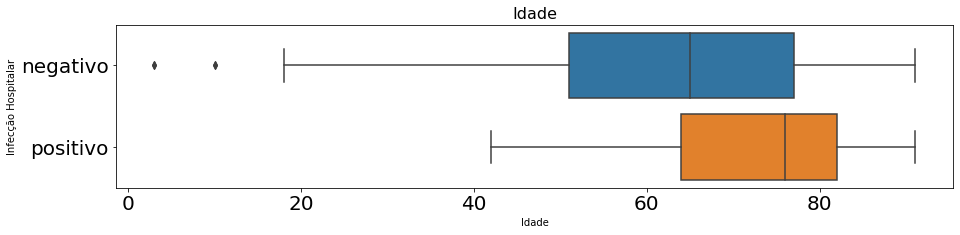

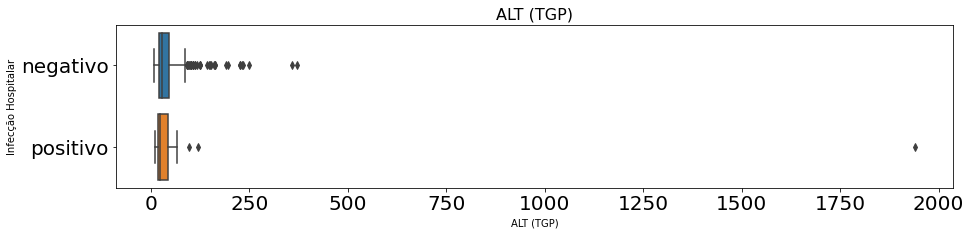

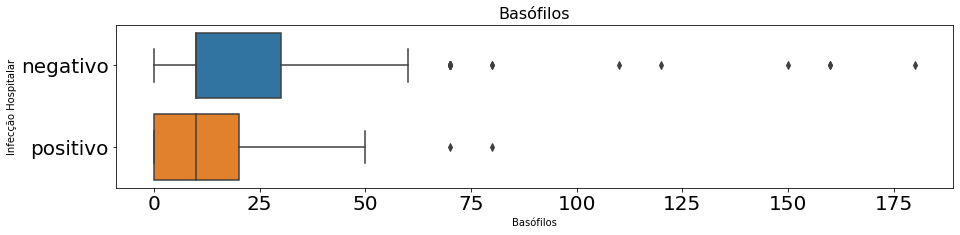

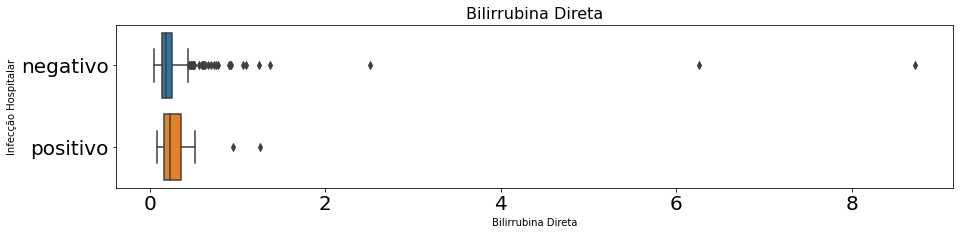

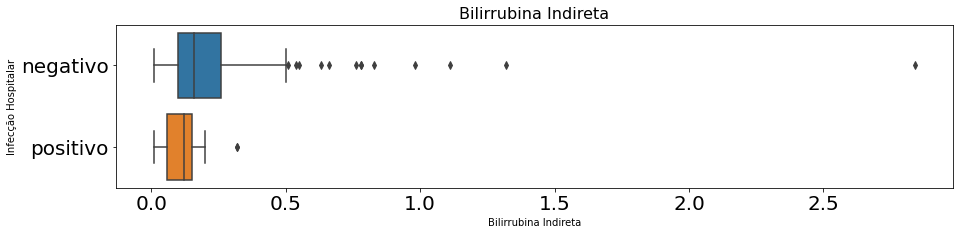

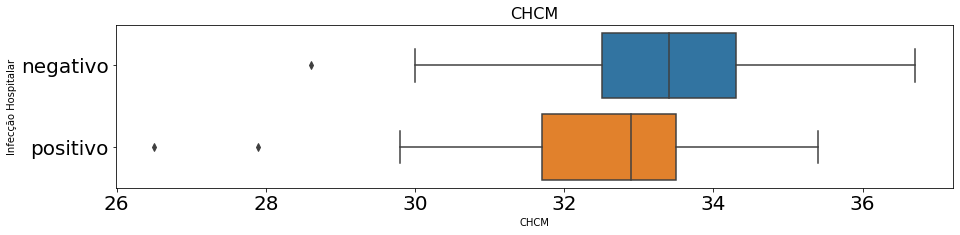

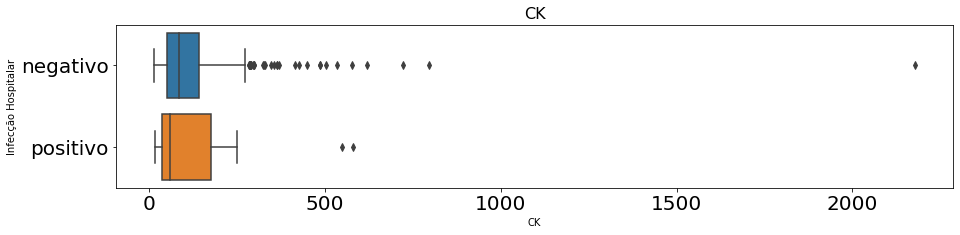

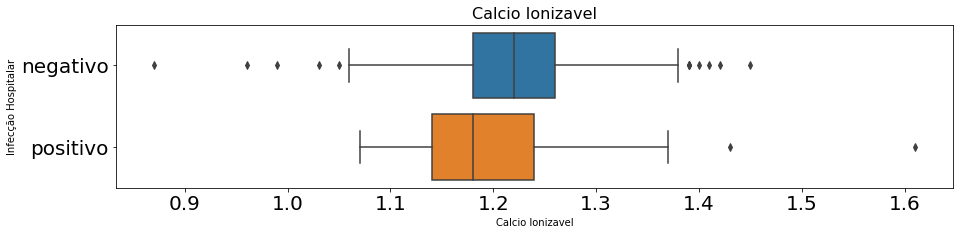

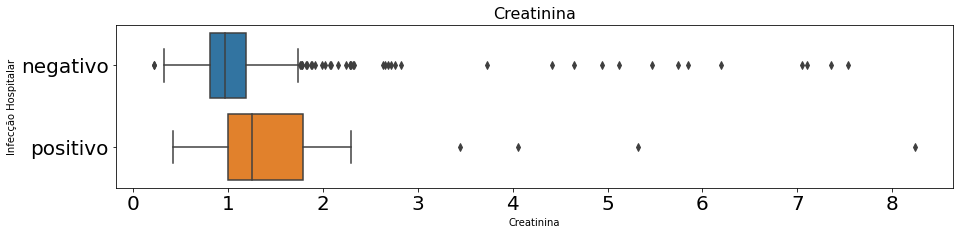

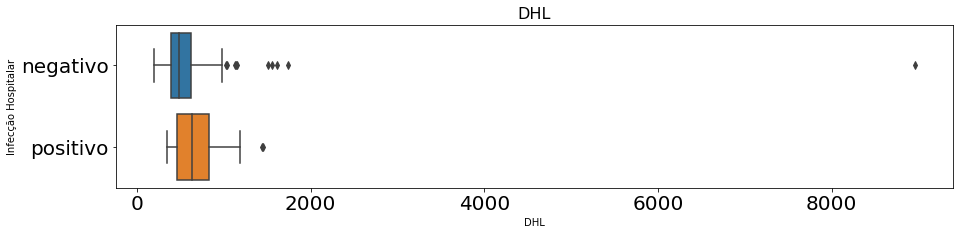

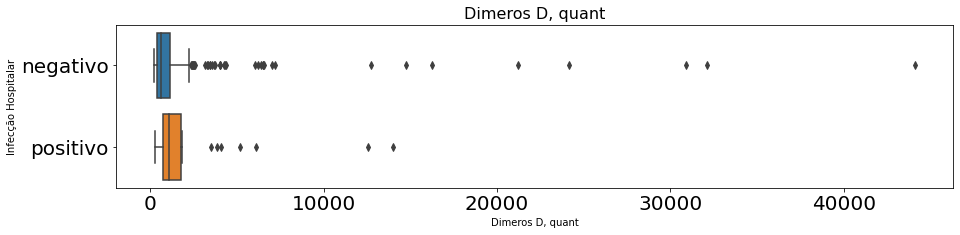

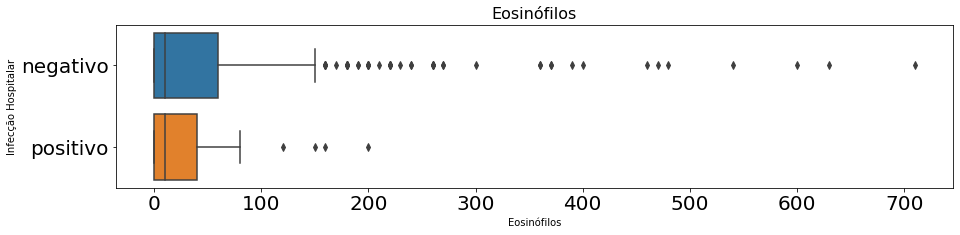

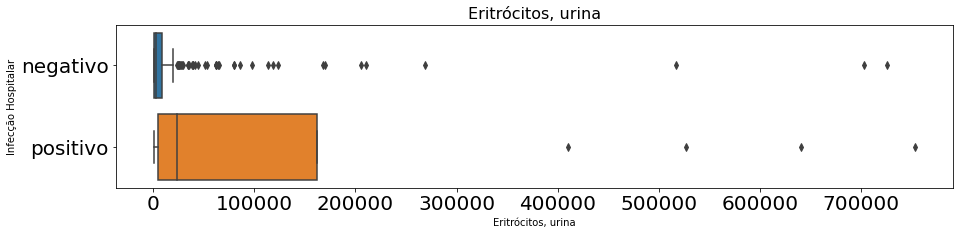

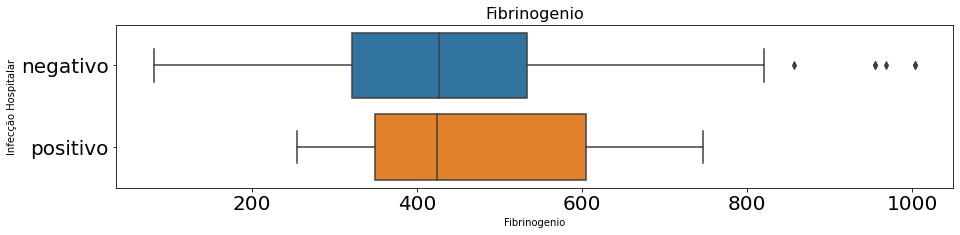

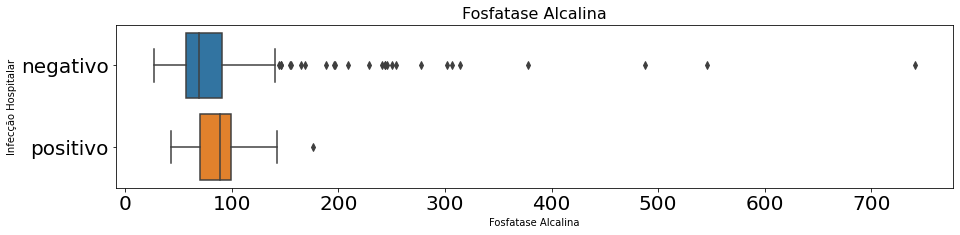

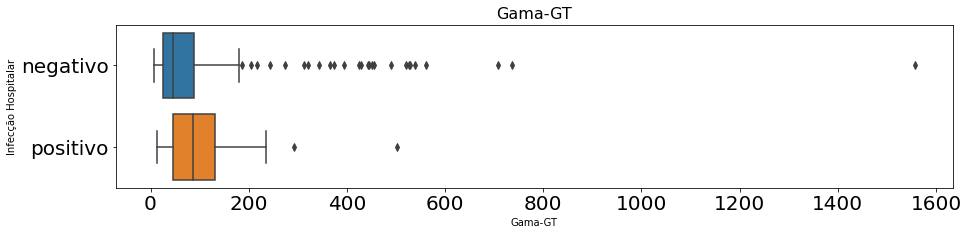

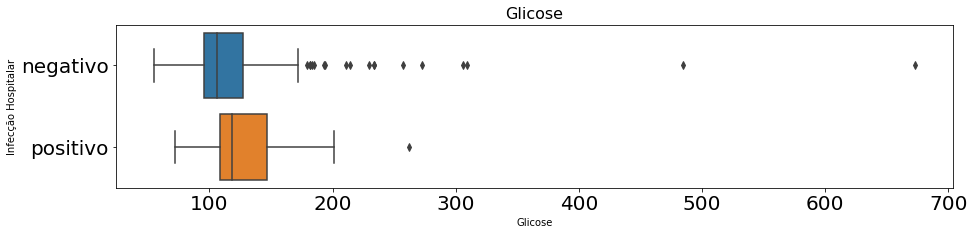

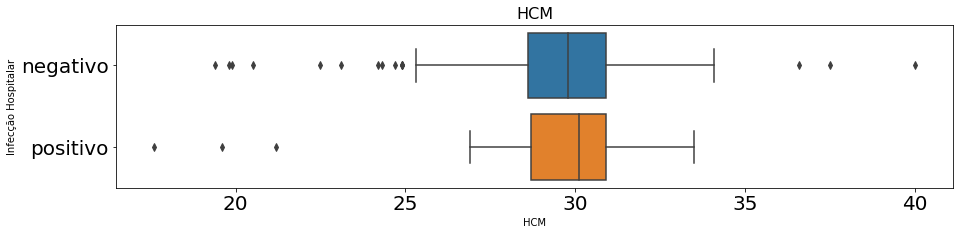

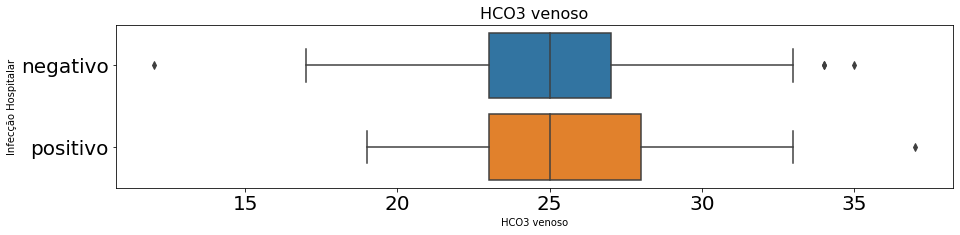

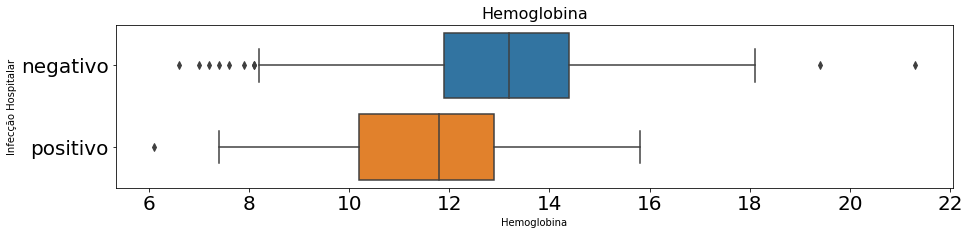

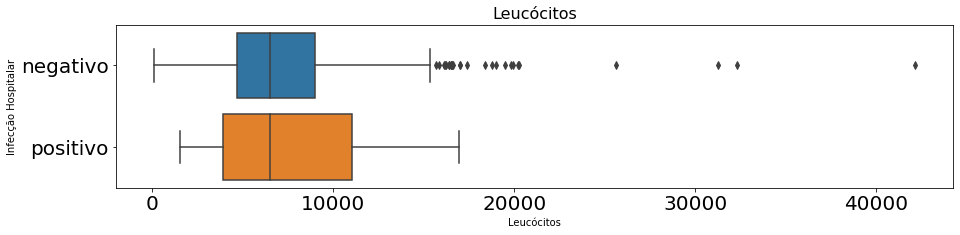

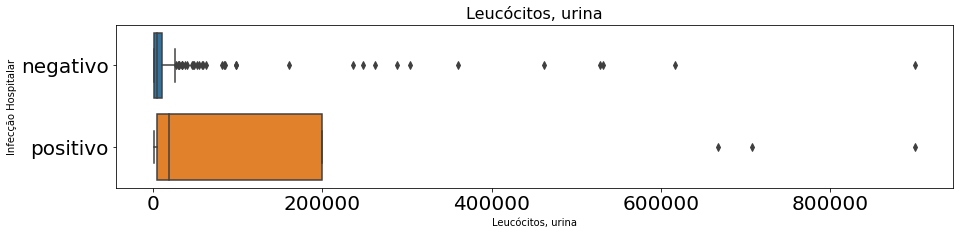

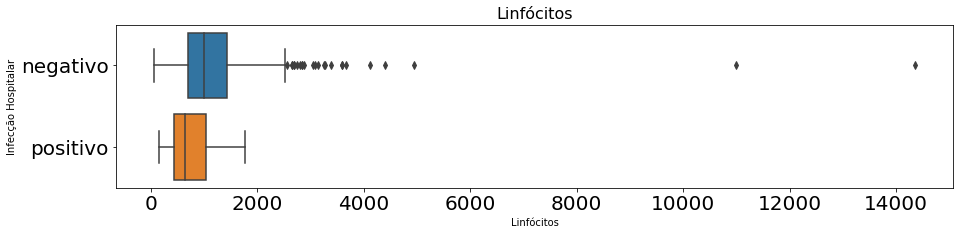

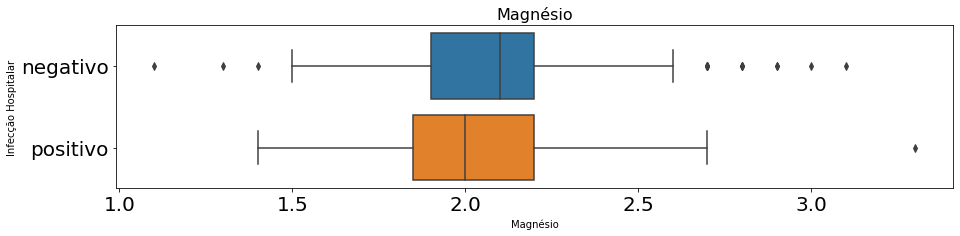

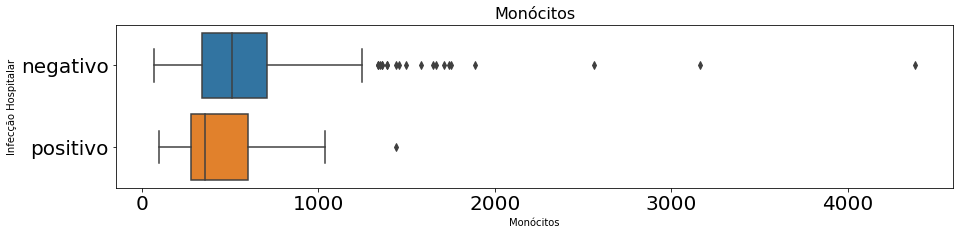

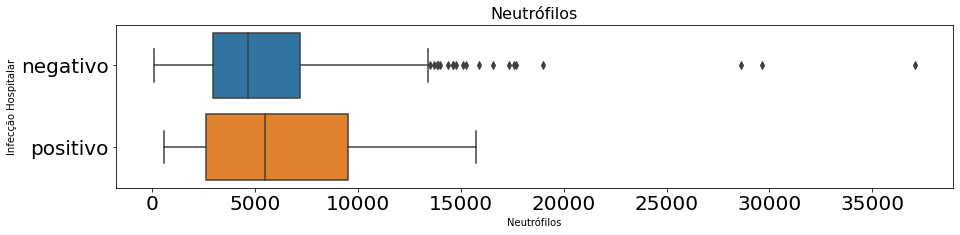

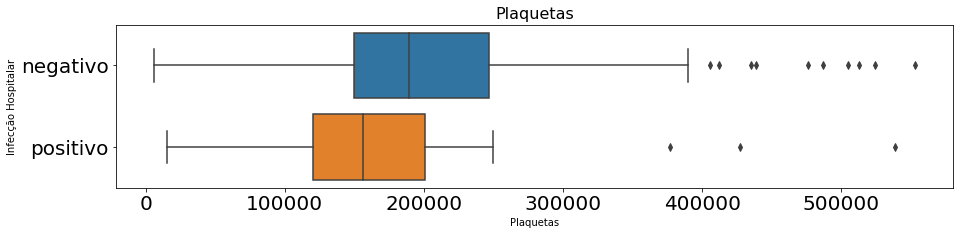

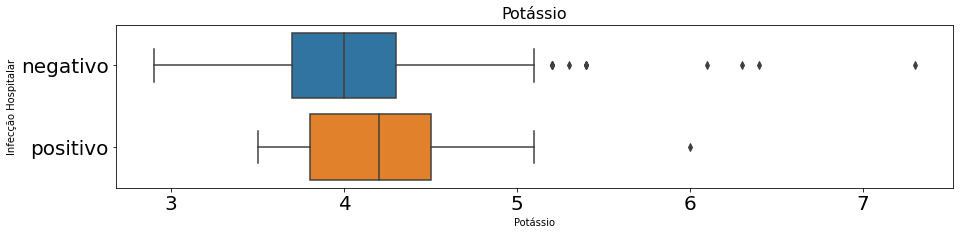

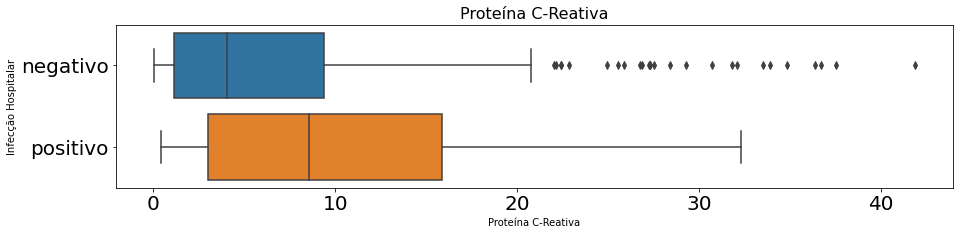

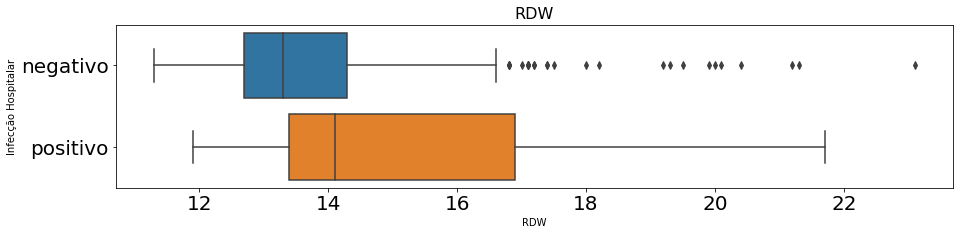

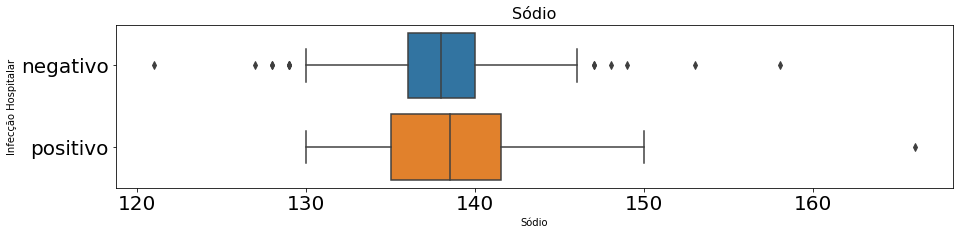

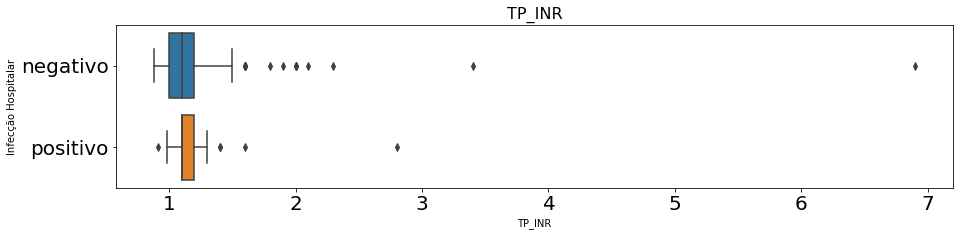

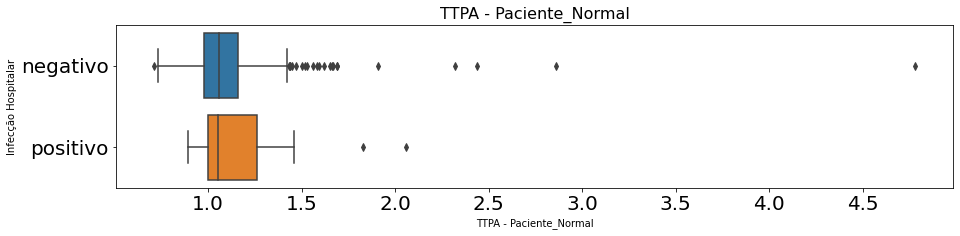

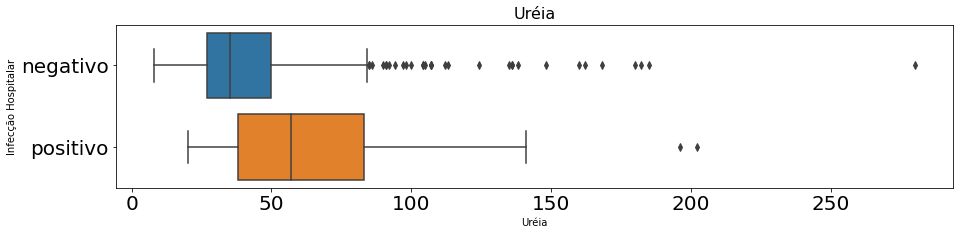

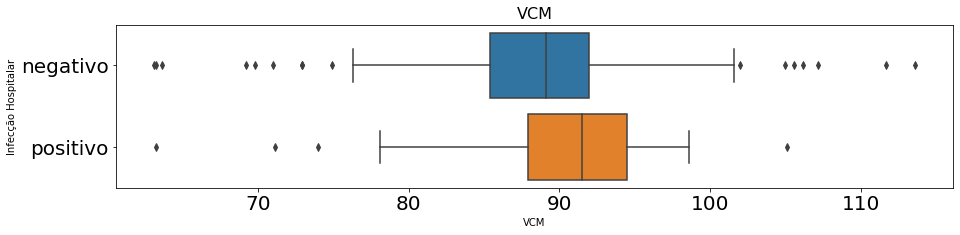

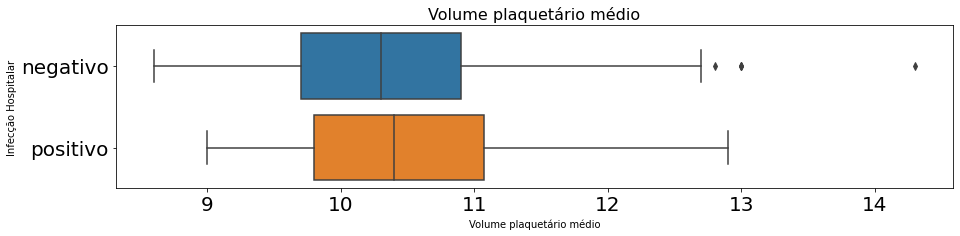

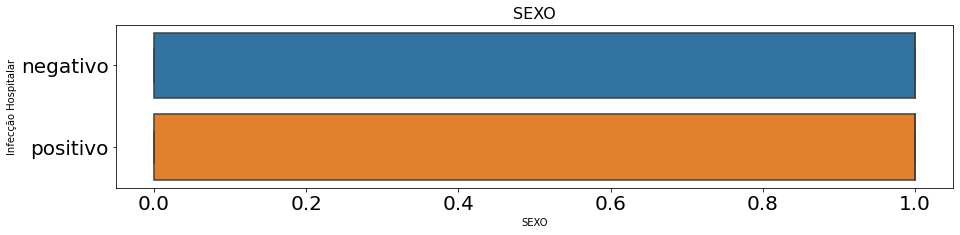

In [355]:
colunas = df7.columns[1:-2]

for i in colunas:
  print_boxplot(i)

In [124]:
df7

,ID_PACIENTE,Idade,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,69,32.0,10.0,0.21,0.15,32.4,194.0,1.17,2.29,...,13.8,138.0,0.99,0.94,91.0,96.0,10.6,1,0.0,negativo
1,009F0D6B3BA6C0E2D406585697D679EB,57,25.0,10.0,0.19,0.15,34.8,153.0,NaN,1.22,...,13.1,137.0,0.97,1.11,38.0,89.5,10.3,1,0.0,negativo
2,0183BA4D9368936BAD131398B55CDDC3,69,142.0,10.0,0.19,0.14,32.8,106.0,1.24,1.20,...,12.7,138.0,1.00,0.95,50.0,84.4,10.8,1,0.0,negativo
3,01A30B6624DDB49F16CA4311CC37D65F,38,25.0,10.0,0.10,0.09,33.8,60.0,NaN,0.98,...,13.0,142.0,NaN,NaN,25.0,83.0,9.4,1,0.0,negativo
4,02367C393B8487123744A46CFBB91A28,74,13.0,10.0,0.18,0.12,33.1,72.0,1.14,0.80,...,13.1,135.0,1.10,1.20,39.0,94.5,9.7,1,0.0,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,FE69345DBB6AE27A1E81775EE898A25B,65,23.0,10.0,0.25,0.27,34.1,225.0,1.26,0.77,...,13.0,138.0,1.30,1.03,26.0,89.7,11.1,1,0.0,negativo
495,FECC5CE1CFE3BCE881F29C2333527135,42,10.0,40.0,NaN,NaN,33.1,NaN,NaN,0.86,...,12.9,139.0,NaN,NaN,29.0,92.5,10.4,0,0.0,negativo
496,FF19A1D8C1EB3A7A73541F3443B4FA00,79,20.0,40.0,0.21,0.22,32.5,170.0,1.22,0.70,...,15.2,142.0,1.20,1.05,27.0,99.2,11.4,0,0.0,negativo
497,FF4B2EED093AE641B9328FDB293C4116,53,40.0,0.0,0.16,0.25,33.3,NaN,1.20,1.05,...,12.7,140.0,0.97,1.06,25.0,84.1,11.0,1,0.0,negativo


In [125]:
df7.to_excel("original_dataset.xlsx")

# 8.0 Dataset discretization

In [126]:
df9 = df7.copy(deep=True)

In [127]:
df9.head(5)

,ID_PACIENTE,Idade,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,69,32.0,10.0,0.21,0.15,32.4,194.0,1.17,2.29,...,13.8,138.0,0.99,0.94,91.0,96.0,10.6,1,0.0,negativo
1,009F0D6B3BA6C0E2D406585697D679EB,57,25.0,10.0,0.19,0.15,34.8,153.0,NaN,1.22,...,13.1,137.0,0.97,1.11,38.0,89.5,10.3,1,0.0,negativo
2,0183BA4D9368936BAD131398B55CDDC3,69,142.0,10.0,0.19,0.14,32.8,106.0,1.24,1.20,...,12.7,138.0,1.00,0.95,50.0,84.4,10.8,1,0.0,negativo
3,01A30B6624DDB49F16CA4311CC37D65F,38,25.0,10.0,0.10,0.09,33.8,60.0,NaN,0.98,...,13.0,142.0,NaN,NaN,25.0,83.0,9.4,1,0.0,negativo
4,02367C393B8487123744A46CFBB91A28,74,13.0,10.0,0.18,0.12,33.1,72.0,1.14,0.80,...,13.1,135.0,1.10,1.20,39.0,94.5,9.7,1,0.0,negativo


In [128]:
colunas = df9.columns
colunas = colunas[2:-3]
colunas

Index(['ALT (TGP)', 'Basófilos', 'Bilirrubina Direta', 'Bilirrubina Indireta',
       'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina', 'DHL',
       'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina', 'Fibrinogenio',
       'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM', 'HCO3 venoso',
       'Hemoglobina', 'Leucócitos', 'Leucócitos, urina', 'Linfócitos',
       'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas', 'Potássio',
       'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio'],
      dtype='object')

In [129]:
for i in colunas:
  df9[i+'_disc'] = np.nan

In [130]:
#df9.drop(['SEXO_disc', 'INFEC_disc', 'Infecção Hospitalar_disc' ], axis=1, inplace=True)

df9.columns

Index(['ID_PACIENTE', 'Idade', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'SEXO', 'INFEC', 'Infecção Hospitalar', 'ALT (TGP)_disc',
       'Basófilos_disc', 'Bilirrubina Direta_disc',
       'Bilirrubina Indireta_disc', 'CHCM_disc', 'CK_disc',
       'Calcio Ionizavel_disc', 'Creatinina_disc', 'DHL_disc',
       'Dimeros D, quant_disc', 'Eosinófilos_disc', 'Eritrócitos, urina_disc',
       'Fibrinogenio_disc', 'Fosfatase Alcalina_disc', 'Gama-GT_disc',
       'Glicose_d

In [131]:
colunas_disc = df9.columns

colunas_disc = colunas_disc[40:]

colunas_disc

Index(['ALT (TGP)_disc', 'Basófilos_disc', 'Bilirrubina Direta_disc',
       'Bilirrubina Indireta_disc', 'CHCM_disc', 'CK_disc',
       'Calcio Ionizavel_disc', 'Creatinina_disc', 'DHL_disc',
       'Dimeros D, quant_disc', 'Eosinófilos_disc', 'Eritrócitos, urina_disc',
       'Fibrinogenio_disc', 'Fosfatase Alcalina_disc', 'Gama-GT_disc',
       'Glicose_disc', 'HCM_disc', 'HCO3 venoso_disc', 'Hemoglobina_disc',
       'Leucócitos_disc', 'Leucócitos, urina_disc', 'Linfócitos_disc',
       'Magnésio_disc', 'Monócitos_disc', 'Neutrófilos_disc', 'Plaquetas_disc',
       'Potássio_disc', 'Proteína C-Reativa_disc', 'RDW_disc', 'Sódio_disc',
       'TP_INR_disc', 'TTPA - Paciente_Normal_disc', 'Uréia_disc', 'VCM_disc',
       'Volume plaquetário médio_disc'],
      dtype='object')

In [132]:
lista_superior = [41,     # ALT (TGP)
                  300,    # Basófilos
                  0.3,    # Bilirrubina Direta
                  0.8,    # Bilirrubina Indireta
                  36,     # CHCM
                  174,    # CK
                  1.4,    # Calcio Ionizavel
                  1.3,    # Creatinina
                  480,    # DHL
                  500,    # Dimeros D, quant
                  500,    # Eosinófilos
                  12000,  # Eritrócitos, urina
                  400,    # Fibrinogenio
                  104,    # Fosfatase Alcalina
                  73,     # Gama-GT
                  99,     # Glicose
                  34,     # HCM
                  27,     # HCO3 venoso
                  15.5,   # Hemoglobina
                  1,      # Leucócitos
                  30000,  # Leucócitos, urina
                  2900,   # Linfócitos
                  2.6,    # Magnésio
                  900,    # Monócitos
                  7000,   # Neutrófilos
                  450000, # Plaquetas
                  4.5,    # Potássio
                  2,     # Proteina c reativa https://www.tuasaude.com/proteina-c-reativa/
                  15.6,   # RDW
                  145,    # Sódio
                  1.1,    # TP/INR
                  1.2,    # TTPA - Paciente/Normal
                  50,     # Uréia
                  95,     # VCM
                  12.6    # Volume plaquetário médio
                  ]

lista_inferior = [5,      # ALT (TGP)
                  0,      # Basófilos
                  0,      # Bilirrubina Direta
                  0.2,    # Bilirrubina Indireta
                  31,     # CHCM
                  38,     # CK
                  1.11,   # Calcio Ionizavel
                  0.7,    # Creatinina
                  240,    # DHL
                  350,    # Dimeros D, quant https://clinicarx.com.br/blog/exame-de-dimero-d
                  50,     # Eosinófilos
                  4000,   # Eritrócitos, urina
                  200,    # Fibrinogenio
                  35,     # Fosfatase Alcalina
                  12,     # Gama-GT
                  75,     # Glicose
                  26,     # HCM
                  23,     # HCO3 venoso
                  12,     # Hemoglobina
                  0,      # Leucócitos, epermograma
                  0,      # Leucócitos, urina
                  900,    # Linfócitos
                  1.6,    # Magnésio
                  300,    # Monócitos
                  1700,   # Neutrófilos
                  150000, # Plaquetas
                  3.5,    # Potássio
                  1,      # Proteina c reativa https://www.tuasaude.com/proteina-c-reativa/
                  11,8,   # RDW
                  136,    # Sódio
                  0,9,    # TP/INR
                  0,91,    # TTPA - Paciente/Normal
                  10,     # Uréia
                  81,     # VCM
                  9,2    # Volume plaquetário médio
                  ]

In [133]:
# ALT analises

limite_superior = 100
limite_inferior = 50

# Function to check if the value is LOW, HIGH or OK
def discretizacao(x, j):
  if x[colunas[j]] > lista_superior[j]:
    retorno = 2 #"ALTO" 
  elif x[colunas[j]] >= lista_inferior[j]:
    retorno = 1 #"OK"
  elif x[colunas[j]] < lista_inferior[j]:
    retorno = 0 #"Baixo"
  else:
    retorno = x[colunas[j]] 
  return retorno

# call function
j = 0
for i in colunas_disc:
    df9[i] = df9.apply( lambda row : discretizacao(row, j), axis = 1)
    j = j+1

df9[['ID_PACIENTE', 'ALT (TGP)', 'ALT (TGP)_disc']].head(50)


,ID_PACIENTE,ALT (TGP),ALT (TGP)_disc
0,004688799FD293C3ABE0A07209FD8B75,32.0,1.0
1,009F0D6B3BA6C0E2D406585697D679EB,25.0,1.0
2,0183BA4D9368936BAD131398B55CDDC3,142.0,2.0
3,01A30B6624DDB49F16CA4311CC37D65F,25.0,1.0
4,02367C393B8487123744A46CFBB91A28,13.0,1.0
5,023B1D40B2A154BBCC3A37EE25AD890D,NaN,NaN
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,12.0,1.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,13.0,1.0
9,0395F9016111258155141750CE8488C1,NaN,NaN


In [134]:
df9[['ID_PACIENTE', 'Proteína C-Reativa', 'Proteína C-Reativa_disc']].head(50)

,ID_PACIENTE,Proteína C-Reativa,Proteína C-Reativa_disc
0,004688799FD293C3ABE0A07209FD8B75,19.76,2.0
1,009F0D6B3BA6C0E2D406585697D679EB,11.04,2.0
2,0183BA4D9368936BAD131398B55CDDC3,13.61,2.0
3,01A30B6624DDB49F16CA4311CC37D65F,1.38,1.0
4,02367C393B8487123744A46CFBB91A28,5.55,2.0
5,023B1D40B2A154BBCC3A37EE25AD890D,0.85,0.0
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,2.54,2.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,5.41,2.0
9,0395F9016111258155141750CE8488C1,2.92,2.0


In [135]:
df9[['ID_PACIENTE', 'Basófilos', 'Basófilos_disc']].head(50)


,ID_PACIENTE,Basófilos,Basófilos_disc
0,004688799FD293C3ABE0A07209FD8B75,10.0,1.0
1,009F0D6B3BA6C0E2D406585697D679EB,10.0,1.0
2,0183BA4D9368936BAD131398B55CDDC3,10.0,1.0
3,01A30B6624DDB49F16CA4311CC37D65F,10.0,1.0
4,02367C393B8487123744A46CFBB91A28,10.0,1.0
5,023B1D40B2A154BBCC3A37EE25AD890D,30.0,1.0
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,30.0,1.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,0.0,1.0
9,0395F9016111258155141750CE8488C1,10.0,1.0


In [136]:
df9

,ID_PACIENTE,Idade,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,Plaquetas_disc,Potássio_disc,Proteína C-Reativa_disc,RDW_disc,Sódio_disc,TP_INR_disc,TTPA - Paciente_Normal_disc,Uréia_disc,VCM_disc,Volume plaquetário médio_disc
0,004688799FD293C3ABE0A07209FD8B75,69,32.0,10.0,0.21,0.15,32.4,194.0,1.17,2.29,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,25.0,10.0,0.19,0.15,34.8,153.0,NaN,1.22,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0183BA4D9368936BAD131398B55CDDC3,69,142.0,10.0,0.19,0.14,32.8,106.0,1.24,1.20,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,01A30B6624DDB49F16CA4311CC37D65F,38,25.0,10.0,0.10,0.09,33.8,60.0,NaN,0.98,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
4,02367C393B8487123744A46CFBB91A28,74,13.0,10.0,0.18,0.12,33.1,72.0,1.14,0.80,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,FE69345DBB6AE27A1E81775EE898A25B,65,23.0,10.0,0.25,0.27,34.1,225.0,1.26,0.77,...,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
495,FECC5CE1CFE3BCE881F29C2333527135,42,10.0,40.0,NaN,NaN,33.1,NaN,NaN,0.86,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
496,FF19A1D8C1EB3A7A73541F3443B4FA00,79,20.0,40.0,0.21,0.22,32.5,170.0,1.22,0.70,...,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0
497,FF4B2EED093AE641B9328FDB293C4116,53,40.0,0.0,0.16,0.25,33.3,NaN,1.20,1.05,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [137]:
# only discretized columns

df9.drop(colunas, axis=1, inplace=True)

In [138]:
df9.head()


,ID_PACIENTE,Idade,SEXO,INFEC,Infecção Hospitalar,ALT (TGP)_disc,Basófilos_disc,Bilirrubina Direta_disc,Bilirrubina Indireta_disc,CHCM_disc,...,Plaquetas_disc,Potássio_disc,Proteína C-Reativa_disc,RDW_disc,Sódio_disc,TP_INR_disc,TTPA - Paciente_Normal_disc,Uréia_disc,VCM_disc,Volume plaquetário médio_disc
0,004688799FD293C3ABE0A07209FD8B75,69,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0183BA4D9368936BAD131398B55CDDC3,69,1,0.0,negativo,2.0,1.0,1.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,01A30B6624DDB49F16CA4311CC37D65F,38,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
4,02367C393B8487123744A46CFBB91A28,74,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [139]:
df9.to_excel("discreted_dataset.xlsx")

# The end